# Redes MLP

Melhores resultados: 

|      | MLP |
|------|------------------|
| RMSE | 35724.18         |
| MAE  | 23680.35         |
| MAPE | 0.30             |

Config:

4 camadas com ativação relu e units (256, 128, 64, 32) e minmax

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import pearsonr
from collections import Counter

from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.random import set_seed

sns.set_palette("Paired")

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

from keras.layers import BatchNormalization

# Constantes e funções

In [2]:
PATH="https://raw.githubusercontent.com/LeiteJu/TCC/main/dados/input/"

SIGLAS = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
  'DF', 'ES', 'GO', 'MA',
  'MG', 'MS', 'MT', 'PA', 'PB',
  'PE', 'PI', 'PR', 'RJ',
  'RN', 'RO', 'RR', 'RS',
  'SC', 'SE', 'SP', 'TO']

LABELS=["subestima: -90%", "subestima entre -90% e 60%", "subestima entre -60% e -30%",
        "subestima entre -30% e 10%", "entre -10% e 10%", "superestima entre 10% e 30%", 
        "superestima entre 30% e 60%", "superestima entre 60% e 90%", "superestima mais de 90%"]

N='NORTE'
NE="NORDESTE"
CO='CENTRO OESTE'
SE='SUDESTE'
S = 'SUL'

REGIOES = {
    'AC': N, 'AL': NE, 'AM' : N, 'AP' : N, 'BA' : NE, 'CE' : NE,
    'DF' : CO, 'ES' : SE, 'GO' : CO, 'MA' : NE,
    'MG' : SE, 'MS' : CO, 'MT' : CO, 'PA' : N, 'PB' : NE,
    'PE' : NE, 'PI' : NE, 'PR' : S, 'RJ' : SE,
    'RN' : NE, 'RO' : N, 'RR' : N, 'RS' : S,
    'SC' : S, 'SE' : NE, 'SP' : SE, 'TO' : N}

In [3]:
# calcula metricas de regressao
def score_regression_metrics(y_test, y_test_pred):

    RMSE = mean_squared_error(y_true=y_test, y_pred=y_test_pred, squared=False)
    MAE = mean_absolute_error(y_true=y_test, y_pred=y_test_pred)
    MAPE = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred)
    R2 = r2_score(y_true=y_test, y_pred=y_test_pred)

    scores = {
        "neg_root_mean_squared_error": RMSE,
        "neg_mean_absolute_error": MAE,
        "neg_mean_absolute_percentage_error": MAPE,
    }

    return scores

def show_scores (scores):

    print ("Scores obtidos:")

    print (f"RMSE: {scores['neg_root_mean_squared_error']}")
    print (f"MAE: {scores['neg_mean_absolute_error']}")
    print (f"MAPE: {scores['neg_mean_absolute_percentage_error']}")

In [4]:
def categorize(x):
    if x < - 0.9:
        return LABELS[0]
    elif x < - 0.6:
        return LABELS[1]
    elif x < - 0.3:
        return LABELS[2]
    elif x < - 0.1:
        return LABELS[3]
    elif x < 0.1:
        return LABELS[4]
    elif x < 0.3:
        return LABELS[5]
    elif x < 0.6:
        return LABELS[6]
    elif x < 0.9:
        return LABELS[7]
    else:
        return LABELS[8]

In [5]:
def show_delta (y_test, y_pred):
    
    data=(y_pred - y_test)/y_test

    error = pd.DataFrame(data, columns=['erro'])
    error['categoria']=error['erro'].apply(categorize)
    
    plt.figure(figsize=(28,6))

    g = sns.countplot(data=error, x='categoria', order=LABELS)
    
    plt.show()

In [6]:
def get_regiao (x):
    return REGIOES[x]

In [7]:
def get_pred (y_test, y_pred):
    
    init = pd.to_datetime("072017", format='%m%Y')
    end = pd.to_datetime("122019", format='%m%Y')
    data = pd.date_range(start=init, end=end, freq='MS').date
    
    pred = pd.DataFrame(list(data) * 27, columns=['data']).sort_values('data')
    
    pred['estados'] = SIGLAS * 30
    
    pred['y_test'] =  y_test[len(y_test) % 27 :].values
    pred['y_pred'] = y_pred[len(y_pred) % 27 :]
    
    pred = pred.set_index('data')
    
    pred['regiao'] = pred['estados'].apply(get_regiao)
    
    return pred

In [120]:
def show_pred (pred, states=SIGLAS):
    
    for state in states:
        
        fig, ax = plt.subplots()

        pred[pred['estados'] == state].plot(y="y_pred", ax=ax, figsize=(12,6), color="coral", title=f"Previsão x Dado Real: {state}", ylabel="Consumo")
        pred[pred['estados'] == state].plot(y="y_test", linestyle=' ', marker="o", ax=ax)

    plt.show()

In [121]:
def show_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
    
    
    plt.title("Visão regional")
    
    for state in reg:
        
        sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
        sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.ylabel="Consumo"
        
    plt.show()

In [9]:
def region_metrics (pred):

    for reg in pred['regiao'].unique():
        
        print (f"Metricas de {reg}:")
        print (f"RMSE: {mean_squared_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'], squared=False)}")
        print (f"MAPE: {mean_absolute_percentage_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print (f"MAE: {mean_absolute_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print ("-------------------------------\n")

In [14]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(18,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(pred, x=pred.index, y='y_test', hue="estados")
    sns.lineplot(pred, x=pred.index, y='y_pred', hue="estados")
    
        
    plt.show()

In [19]:
def split_train_test_validation (x, y):
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, shuffle=False)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle=False)

# SEED

In [11]:
SEED = 41

def set_seeds (SEED=41):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    set_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

In [12]:
set_seeds(SEED)

# Dados

In [15]:
def load_data():
    
    df = pd.read_csv(f"{PATH}processado.csv")
    
    x  = df.copy()
    x = x.sort_values(["data", "estados"])
    x = x.drop(["consumo", 'data'], axis=1)

    y = df.copy().sort_values(["data", "estados"])[['estados', 'data', 'consumo']]
    
    # processo de one-hot
    x = pd.get_dummies(data=x, columns=["estados"], drop_first=True)

    y = y['consumo']
    
    return x,y

# Experimentos

## 1 camada de 16 neurônios

In [16]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=16, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

In [17]:
show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 247356.83564931896
MAE: 147654.2215069418
MAPE: 0.9363750094252453
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 204905.72048572573
MAE: 127943.09992699814
MAPE: 0.8666399019176667


## 1 camada de 32 neurônios

In [129]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 218250.1393228356
MAE: 130234.74269842633
MAPE: 0.8746592700290485
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 166145.15213151067
MAE: 101965.3869633692
MAPE: 0.7387956151494


## 2 camadas (64, 32)

In [130]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 47077.45704469229
MAE: 29392.3360141927
MAPE: 0.3781404727295164
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 74701.33229080414
MAE: 43369.511122716234
MAPE: 0.4843290624419502


In [131]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 46437.395932640175
MAE: 27044.9488660576
MAPE: 0.3588282487268094
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 83890.67003283024
MAE: 54124.65654078418
MAPE: 0.7626164899459138


## 3 camadas (128, 64, 32)

### StandardScaler

In [132]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 31777.14595561428
MAE: 17652.733353265066
MAPE: 0.24598927636079493
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 44519.96296107601
MAE: 30388.38663254799
MAPE: 0.5894218289033246


### MinMax Scaler

In [133]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 38041.52837804079
MAE: 21230.317434207936
MAPE: 0.3279675306259006
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 70500.13519137503
MAE: 41265.27863441846
MAPE: 0.5347937753328799


## 3 camadas (256, 128, 64)

### Standard Scaler

In [134]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 30131.132426431624
MAE: 16534.43286393883
MAPE: 0.2190166858610891
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 43755.36702107525
MAE: 30338.791136071646
MAPE: 0.6100094978897368


### MinMax Scaler

#### 100 epochs

In [135]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 32803.54842672395
MAE: 18521.202397736946
MAPE: 0.2686803310480784
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 54979.7456459006
MAE: 34599.293916972114
MAPE: 0.5178527748763385


#### 200 epochs

In [136]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 29587.060727903412
MAE: 16024.43344986381
MAPE: 0.20693813948030687
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 38864.206685995145
MAE: 25925.152220941658
MAPE: 0.41956528536096266


#### 300 epochs

In [137]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 27975.498721064894
MAE: 15246.693977535098
MAPE: 0.1980162611621636
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 37376.8176567423
MAE: 25048.33820532138
MAPE: 0.37227871588758704


#### 400 epochs

In [138]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=400, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 25877.926650775116
MAE: 14254.521494718094
MAPE: 0.17892248090545299
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 36371.3857594817
MAE: 22538.66977190712
MAPE: 0.26623841311589647


## 4 camadas (256, 128, 64, 32)

### Standard Scaler

#### 100 epochs

In [139]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 26958.800064562223
MAE: 14501.38083610625
MAPE: 0.1881364385259486
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 43979.22010454599
MAE: 30613.860144913844
MAPE: 0.6057417740953225


### MinMax Scaler

#### 100 epochs

In [140]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 31996.166512262527
MAE: 18510.671963027897
MAPE: 0.26311635237999864
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 48640.71819794183
MAE: 32781.172355605726
MAPE: 0.535225668381961


#### 200 epochs

In [141]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 28301.615337365085
MAE: 15081.51046122206
MAPE: 0.1814278383449915
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 38314.04201546073
MAE: 25757.79574138452
MAPE: 0.38724185031425606


In [142]:
x,y = load_data()

DROP=['pib_pc',  'selic', 'idh_e', 'idh_l', 'nfsp', 'preco_ton', 'estoque']
x=x.drop(DROP, axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 36731.79112813412
MAE: 20958.08296333395
MAPE: 0.2511676370979884
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 52090.49881988729
MAE: 31840.046317048633
MAPE: 0.38096104430331656


#### 300 epochs

In [143]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 25535.2278217785
MAE: 13849.259952090337
MAPE: 0.17634605506334644
26/26 [==============================] - 0s 4ms/step
Scores obtidos:
RMSE: 40553.857985030445
MAE: 28227.548421912787
MAPE: 0.44361389703193926


In [144]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 32782.8820404526
MAE: 17489.298374091657
MAPE: 0.21916392284605712
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 42234.69340866941
MAE: 28182.23825645216
MAPE: 0.4654198511285563


In [145]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=512, activation="relu")),
model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=300, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 1s 3ms/step
Scores obtidos:
RMSE: 24903.046258932383
MAE: 13424.587360423095
MAPE: 0.14397350801340203
26/26 [==============================] - 0s 3ms/step
Scores obtidos:
RMSE: 42105.315004997225
MAE: 27889.534275336307
MAPE: 0.3899539343375384


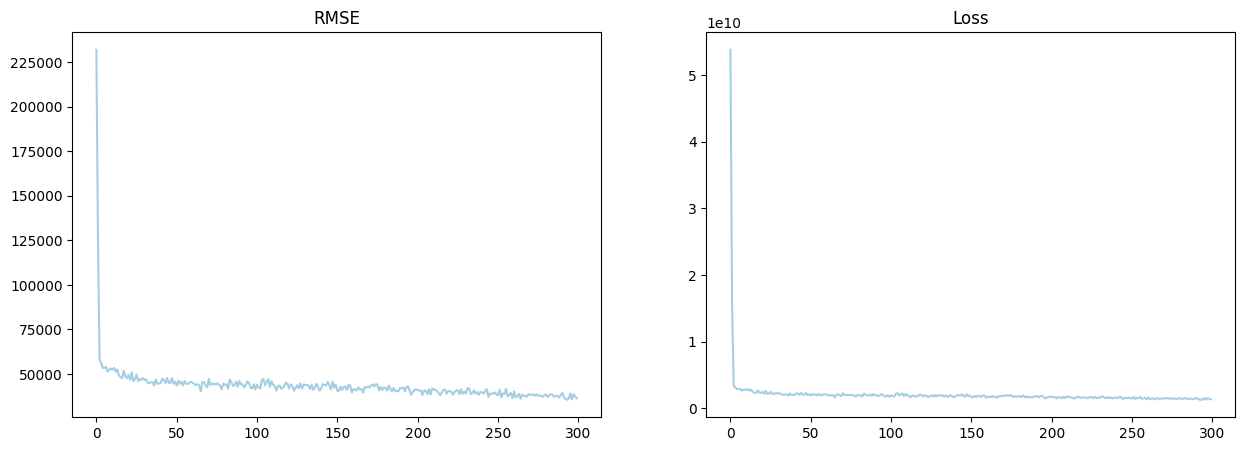

In [146]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)

plt.plot(history.history["RMSE"])
plt.title("RMSE")

plt.subplot(1,2,2)

plt.plot(history.history["loss"])
plt.title("Loss")

plt.show()

In [ ]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=32, activation="swish")),
model.add(Dense(units=16, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

### Swish

In [148]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),
model.add(Dense(units=64, activation="swish")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Epoch 1/100
147/147 [==============================] - 1s 3ms/step - loss: 71488356352.0000 - RMSE: 267373.0625
Epoch 2/100
147/147 [==============================] - 0s 3ms/step - loss: 67342655488.0000 - RMSE: 259504.6406
Epoch 3/100
147/147 [==============================] - 0s 3ms/step - loss: 49473417216.0000 - RMSE: 222426.2031
Epoch 4/100
147/147 [==============================] - 0s 3ms/step - loss: 32769261568.0000 - RMSE: 181022.8281
Epoch 5/100
147/147 [==============================] - 1s 4ms/step - loss: 17695793152.0000 - RMSE: 133025.5312
Epoch 6/100
147/147 [==============================] - 0s 3ms/step - loss: 8816667648.0000 - RMSE: 93897.1094
Epoch 7/100
147/147 [==============================] - 0s 3ms/step - loss: 5008403968.0000 - RMSE: 70770.0781
Epoch 8/100
147/147 [==============================] - 0s 3ms/step - loss: 3438396160.0000 - RMSE: 58637.8398
Epoch 9/100
147/147 [==============================] - 0s 3ms/step - loss: 3014039808.0000 - RMSE: 54900.2695


In [149]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="swish")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=100, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

Epoch 1/100
147/147 [==============================] - 1s 3ms/step - loss: 70294151168.0000 - RMSE: 265130.4375
Epoch 2/100
147/147 [==============================] - 0s 3ms/step - loss: 45047181312.0000 - RMSE: 212243.2188
Epoch 3/100
147/147 [==============================] - 0s 3ms/step - loss: 30367266816.0000 - RMSE: 174262.0625
Epoch 4/100
147/147 [==============================] - 0s 3ms/step - loss: 22963105792.0000 - RMSE: 151535.8281
Epoch 5/100
147/147 [==============================] - 0s 3ms/step - loss: 13702219776.0000 - RMSE: 117056.4844
Epoch 6/100
147/147 [==============================] - 0s 3ms/step - loss: 6578806784.0000 - RMSE: 81109.8438
Epoch 7/100
147/147 [==============================] - 0s 3ms/step - loss: 3726157824.0000 - RMSE: 61042.2617
Epoch 8/100
147/147 [==============================] - 0s 3ms/step - loss: 2892472064.0000 - RMSE: 53781.7070
Epoch 9/100
147/147 [==============================] - 0s 3ms/step - loss: 2566478848.0000 - RMSE: 50660.4258


# Gráficos

In [150]:
set_seeds(41)

x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=256, activation="relu")),
model.add(Dense(units=128, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=32, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

147/147 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 27185.92161126942
MAE: 14674.339372794258
MAPE: 0.19035243630137
26/26 [==============================] - 0s 2ms/step
Scores obtidos:
RMSE: 38406.38056420336
MAE: 26274.873339725666
MAPE: 0.42426139046892697


In [151]:
pred = get_pred(y_test, y_pred)

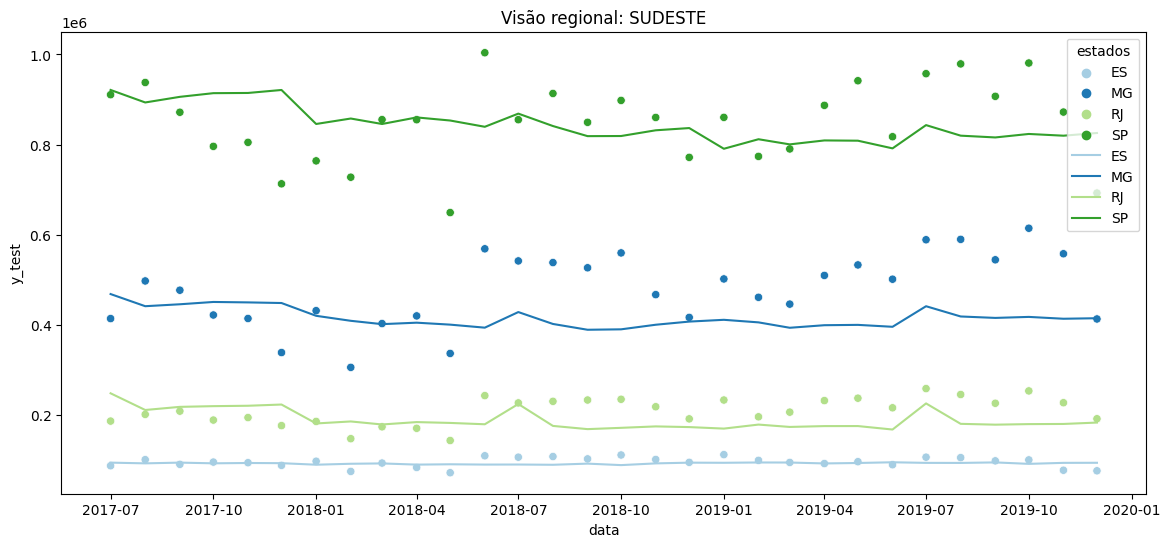

In [152]:
region_graphs(pred, 'SUDESTE')

In [153]:
def show_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
    
    
    plt.title("Visão regional")
    
    for state in reg:
        
        sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
        sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.ylabel="Consumo"
        
    plt.show()

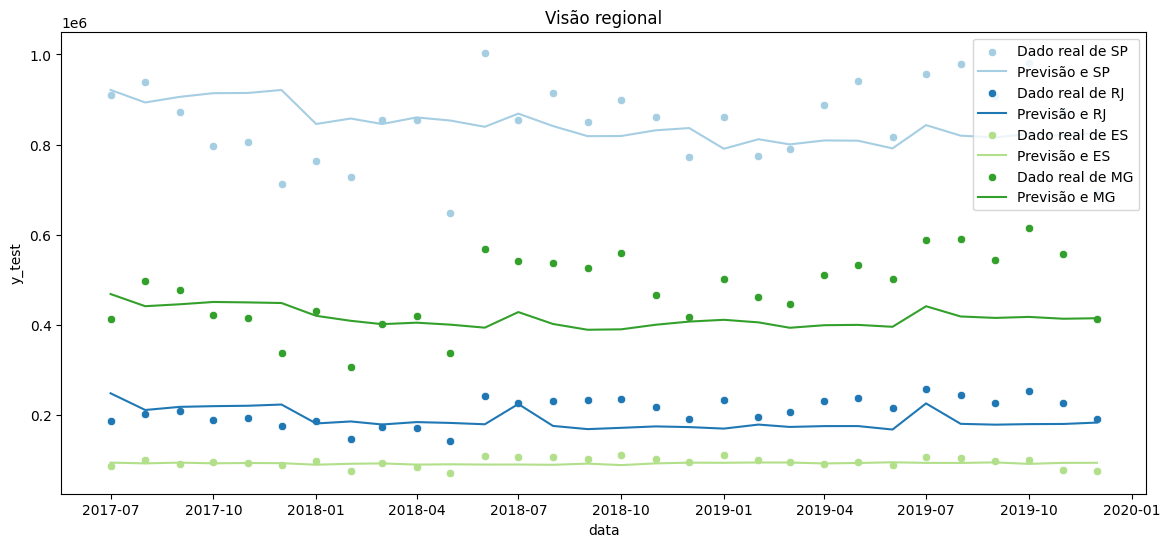

In [154]:
SUDESTE = ['SP', 'RJ', 'ES', 'MG']

show_graphs(pred, SUDESTE)

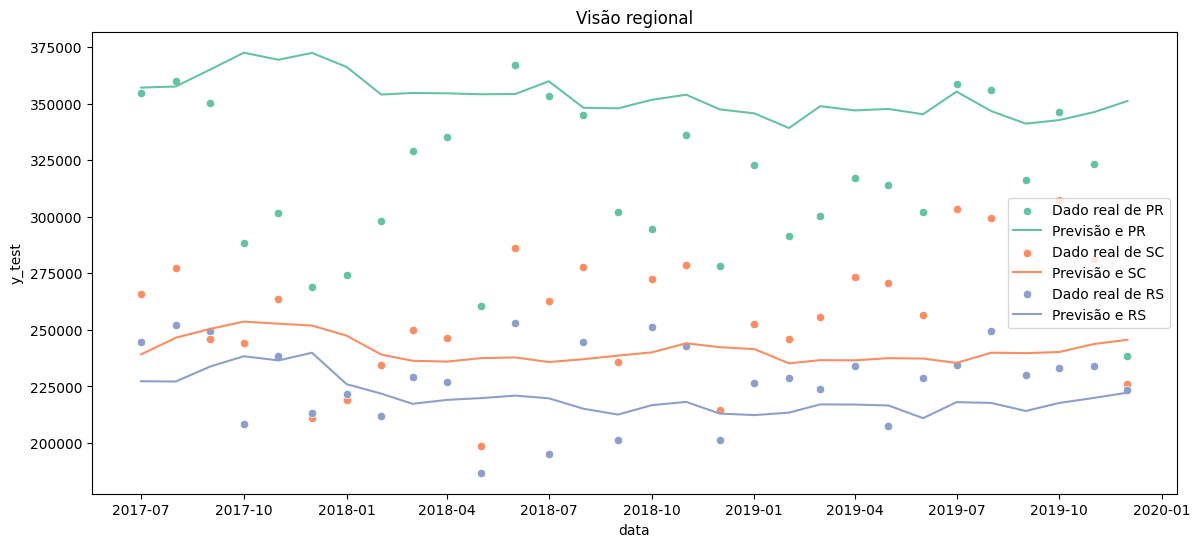

In [155]:
SUL = ['PR', 'SC', 'RS']

sns.set_palette("Set2")

show_graphs(pred, SUL)

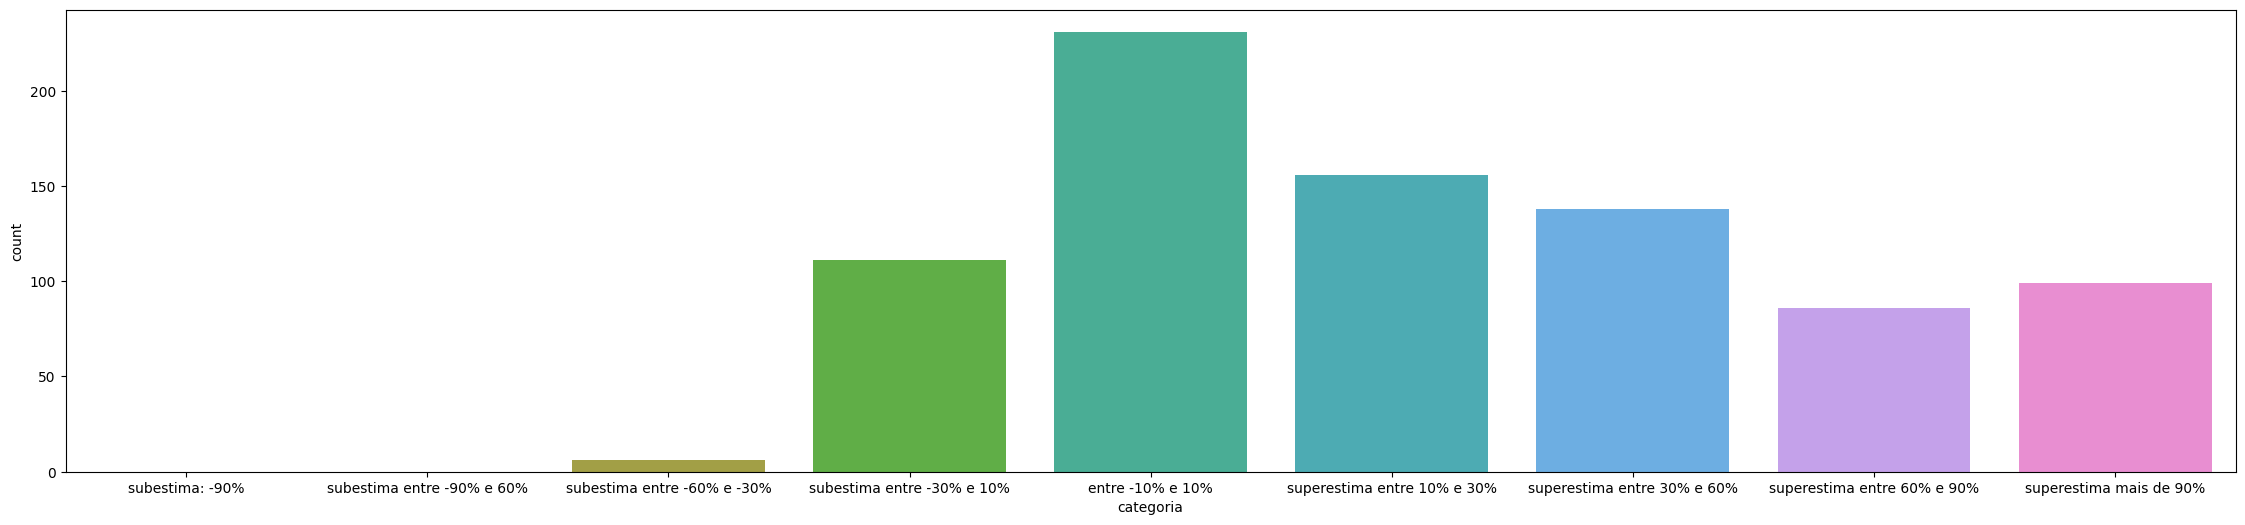

In [156]:
show_delta(np.array(y_test), y_pred.flatten())

In [18]:
#Best: -53222.032266 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.1, 'model__epochs': 200, 'model__learning_rate': 0.001, 'model__n_layers': 3, 'model__n_units': 64}


In [ ]:
x,y = load_data()

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.15, shuffle=False)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = Sequential()

model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=64, activation="relu")),
model.add(Dense(units=64, activation="relu")),

model.add(Dropout(rate=0.10))
model.add(Dense(units=1))
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=[keras.metrics.RootMeanSquaredError(name="RMSE")],
)

history=model.fit(x_train, y_train, batch_size=32, epochs=200, verbose=0)

show_scores(score_regression_metrics(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
scores = score_regression_metrics(y_test, y_pred)
show_scores(scores)

In [ ]:
pred = get_pred(y_test, y_pred)

In [ ]:
def region_graphs (pred, reg):
    
    plt.figure(figsize=(14,6))
        
    plt.title(f"Visão regional: {reg}")
    
    pred=pred[pred['regiao'] == reg]
    
    plt.ylabel="Consumo"
    sns.scatterplot(pred, x=pred.index, y='y_test', hue="estados")
    sns.lineplot(pred, x=pred.index, y='y_pred', hue="estados")
    
#     for state in reg:
        
#         sns.scatterplot(pred[pred['estados'] == state]['y_test'], label=f"Dado real de {state}")
#         sns.lineplot(pred[pred['estados'] == state]['y_pred'], label=f"Previsão e {state}")
        
    plt.show()

In [ ]:
region_graphs(pred, 'SUDESTE')

In [ ]:
region_graphs(pred, 'NORDESTE')

In [ ]:
def region_metrics (pred):

    for reg in pred['regiao'].unique():
        
        print (f"Metricas de {reg}:")
        print (f"RMSE: {mean_squared_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'], squared=False)}")
        print (f"MAPE: {mean_absolute_percentage_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print (f"MAE: {mean_absolute_error(pred[pred['regiao'] == reg]['y_test'], pred[pred['regiao'] == reg]['y_pred'])}")
        print ("-------------------------------\n")

In [ ]:
region_metrics(pred)